# Binning Studies

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
import os

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [3]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "model_version":   "v0",
    "samples_version": "v0",
    "cols": ['detajj',
             'eta1',
             'eta2',
             'detall',        
             'jetpt1', 
             'jetpt2', 
             'met',
             'dphill',
             'dphijj',
             'Mll',
             'btag_first',
             'dR_jl1',
             'dR_jl2',
             'Zeppll'
           ]
}

In [4]:
config_base_dir = os.path.join(config["base_dir"], config["plot_config"])
# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

#for key in ["samples_version", "cols"]:
#    config[key] = model_config[key]

In [5]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
print(samples_dir)
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

/eos/home-b/bpinolin/ML_output/VBSOS/sr/samples/v0


In [6]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [7]:
scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [8]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W0519 09:53:34.257952 139639131838272 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0519 09:53:35.148944 139639131838272 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                450       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [9]:
bkg_linf = bkg[config["cols"]].values

<a id = 'DNNoutput' ></a>
## DNN output

In [32]:
import ROOT
from ROOT import TFile, TCanvas, TF1

In [33]:
inFile = TFile.Open("c_em_medium_DNNoutput_emmedium.root" ," READ ")

In [34]:
c1 = inFile.Get("ccem_medium_DNNoutput_emmedium");

In [35]:
c1.GetListOfPrimitives().At(2).ls()

THStack Name= thsBackground_grouped_em_medium_DNNoutput_emmedium Title= thsBackground_grouped_em_medium_DNNoutput_emmedium Option=
 OBJ: TList	TList	Doubly linked list : 0
  OBJ: TH1D	new_histo_group_top_em_medium_DNNoutput_emmedium	histo_top : 0 at: 0x10b4f880
  OBJ: TH1D	new_histo_group_WWewk_em_medium_DNNoutput_emmedium	histo_WWewk : 0 at: 0x985ae10


In [36]:
c1.GetListOfPrimitives().At(3).ls()

THStack Name= thsSignal_grouped_em_medium_DNNoutput_emmedium Title= thsSignal_grouped_em_medium_DNNoutput_emmedium Option=
 OBJ: TList	TList	Doubly linked list : 0
  OBJ: TH1D	new_histo_group_WWewk_em_medium_DNNoutput_emmedium	histo_WWewk : 0 at: 0x985ae10


## signal

In [14]:
stack = c1.GetListOfPrimitives().FindObject("thsSignal_grouped_em_medium_DNNoutput_emmedium")

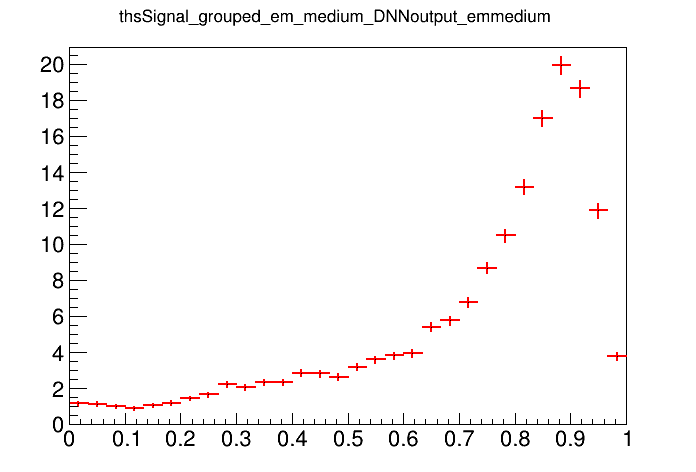

In [15]:
c = TCanvas()
stack.Draw()
c.Draw()

In [16]:
d = stack.GetStack().Last()
type(d)

ROOT.TH1D

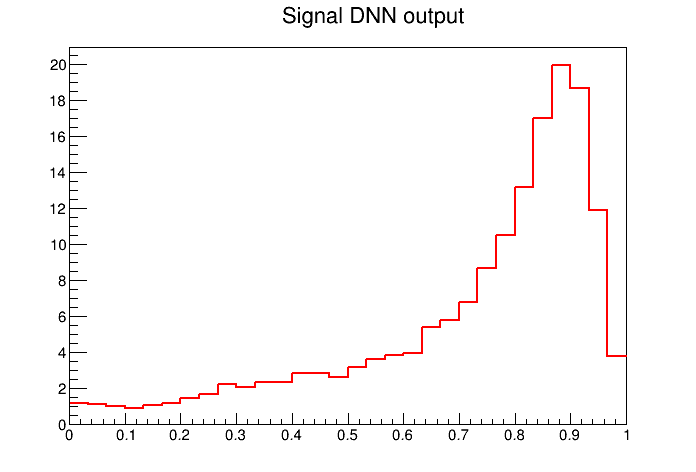

In [17]:
c1 = TCanvas("","")
d.Draw("HIST")
ROOT.gStyle.SetOptStat(0);
d.SetTitle("Signal DNN output");
c1.Draw()

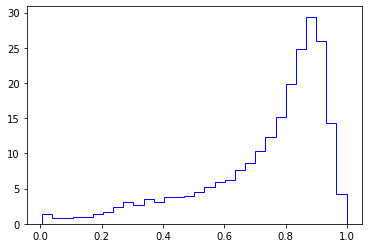

In [18]:
lumi = 59.74
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)
S, S_bins, _ = plt.hist(signal["y"], weights=signal.weight_*lumi, bins=30, histtype="step", color="blue")

In [19]:
d1 = ROOT.TH1D("hist","hist",30,0,1)
for i in range(len(S)):
    d1.SetBinContent(i+1,S[i])

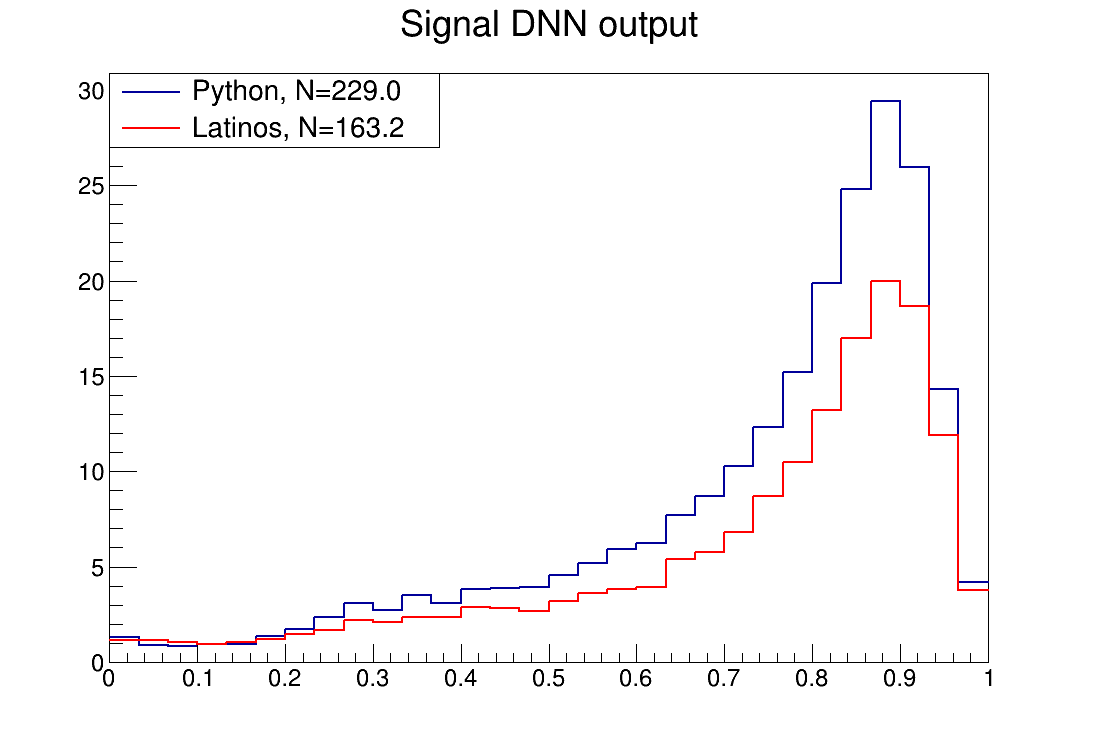

In [21]:
c2 = TCanvas("","")
c2.SetWindowSize(1500,1000)

d1.Draw("HIST")
d.Draw("HIST SAME")

d1.SetLineWidth(2)
d1.SetTitle("Signal DNN output");

ROOT.gStyle.SetOptStat(0);

legend = ROOT.TLegend(0.1,0.8,0.4,0.9);
legend.AddEntry(d1,"Python, N="+str(round((signal.weight_).sum()*lumi,1)),"l");
legend.AddEntry(d,"Latinos, N=163.2","l");

legend.Draw();

c2.Draw()

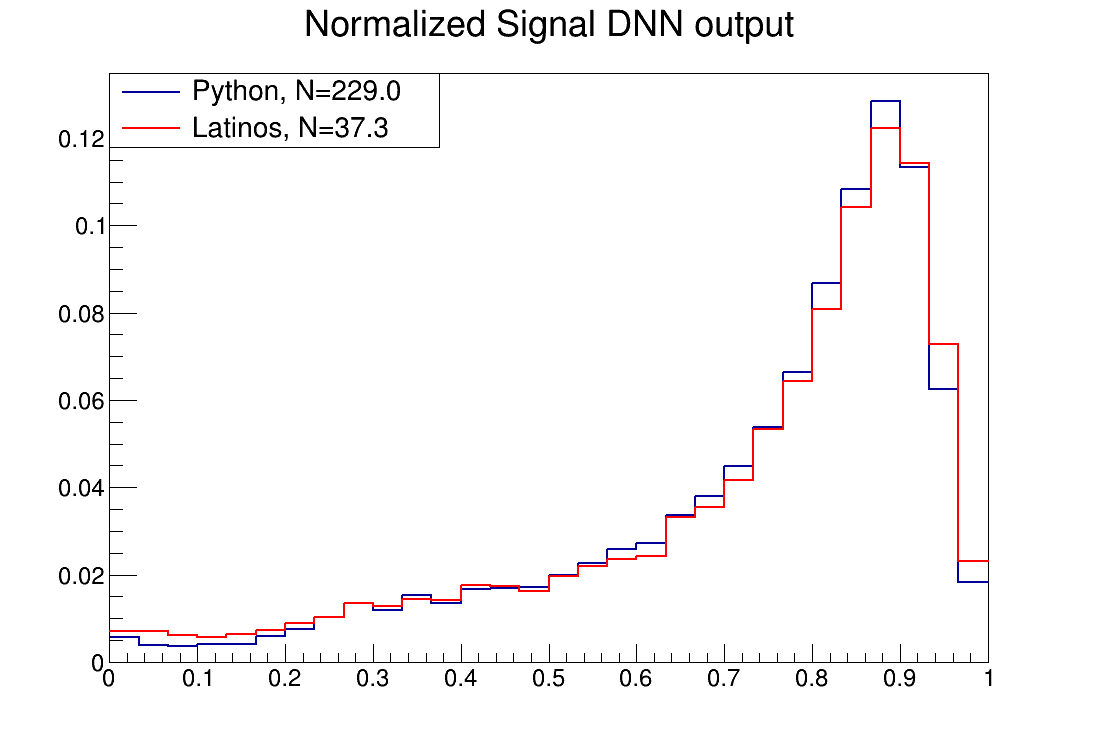

In [23]:
c3 = TCanvas("","")
c3.SetWindowSize(1500,1000)

d1.Draw("HIST")
d.Draw("HIST SAME")

d.Scale(1/(d.Integral()));
d1.Scale(1/(d1.Integral()));

d1.SetLineWidth(2)
d1.SetTitle("Normalized Signal DNN output");

ROOT.gStyle.SetOptStat(0);

legend = ROOT.TLegend(0.1,0.8,0.4,0.9);
legend.AddEntry(d1,"Python, N="+str(round((signal.weight_).sum()*lumi,1)),"l");
legend.AddEntry(d,"Latinos, N=37.3","l");



legend.Draw();

c3.Draw()

## top

In [37]:
stack = c1.GetListOfPrimitives().FindObject("thsBackground_grouped_em_medium_DNNoutput_emmedium")

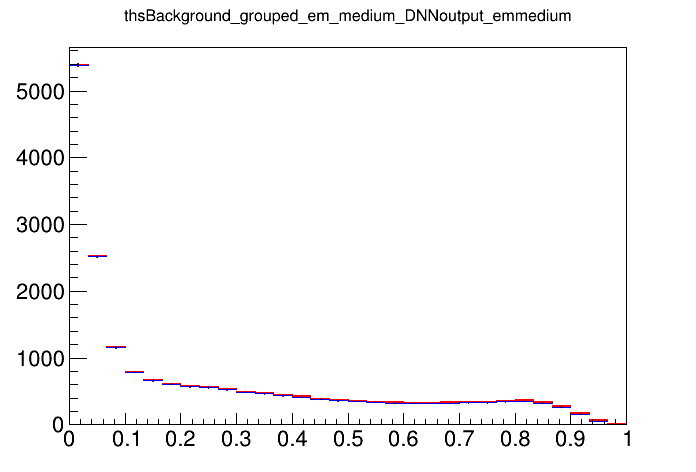

In [38]:
c = TCanvas()
stack.Draw()
c.Draw()

In [39]:
d = stack.GetStack().Last()
type(d)

ROOT.TH1D

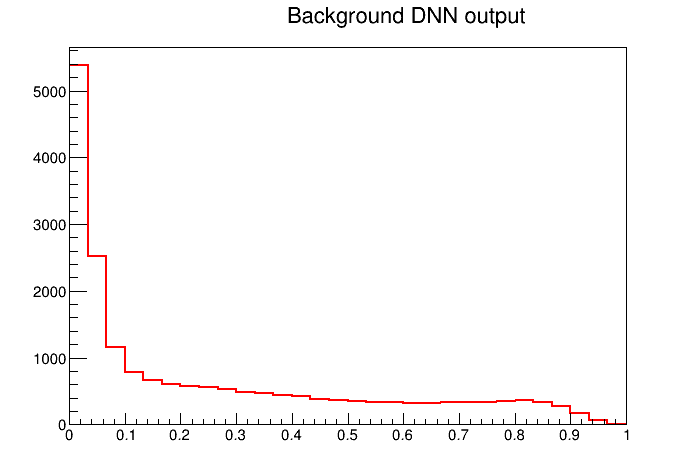

In [40]:
c1 = TCanvas("","")
d.Draw("HIST")
ROOT.gStyle.SetOptStat(0);
d.SetTitle("Background DNN output");
c1.Draw()

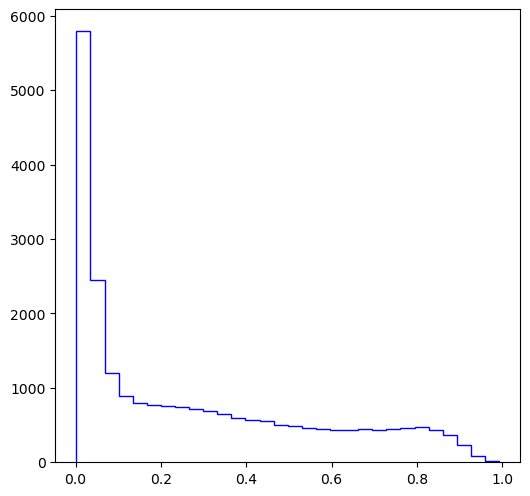

In [41]:
lumi = 59.74
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)
S, S_bins, _ = plt.hist(bkg["y"], weights=bkg.weight_*lumi, bins=30, label="Python, N = "+str(round((bkg.weight_).sum()*lumi,1)), histtype="step", color="blue")

In [42]:
d1 = ROOT.TH1D("hist","hist",30,0,1)
for i in range(len(S)):
    d1.SetBinContent(i+1,S[i])

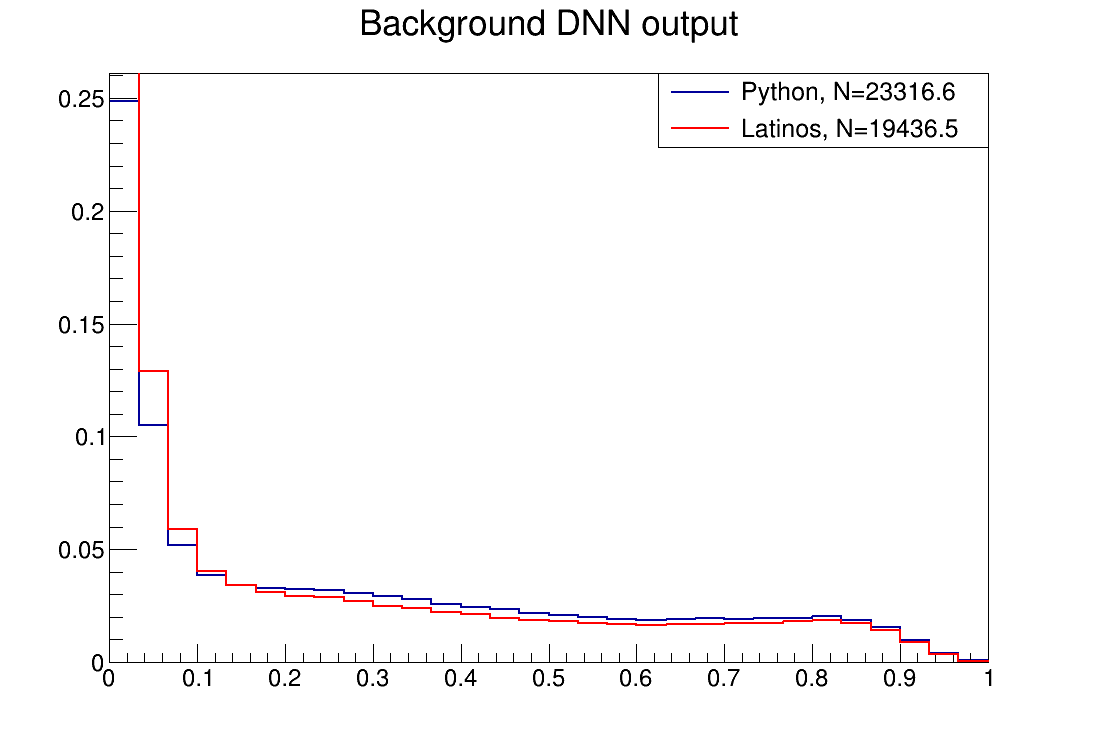

In [46]:
c2 = TCanvas("","")
c2.SetWindowSize(1500,1000)

d1.Draw("HIST")
d.Draw("HIST SAME")

d1.SetLineWidth(2)
d1.SetTitle("Background DNN output");

ROOT.gStyle.SetOptStat(0);

legend = ROOT.TLegend(0.6,0.8,0.9,0.9);
legend.AddEntry(d1,"Python, N="+str(round((bkg.weight_).sum()*lumi,1)),"l");
legend.AddEntry(d,"Latinos, N=19436.5","l");

legend.Draw();

c2.Draw()

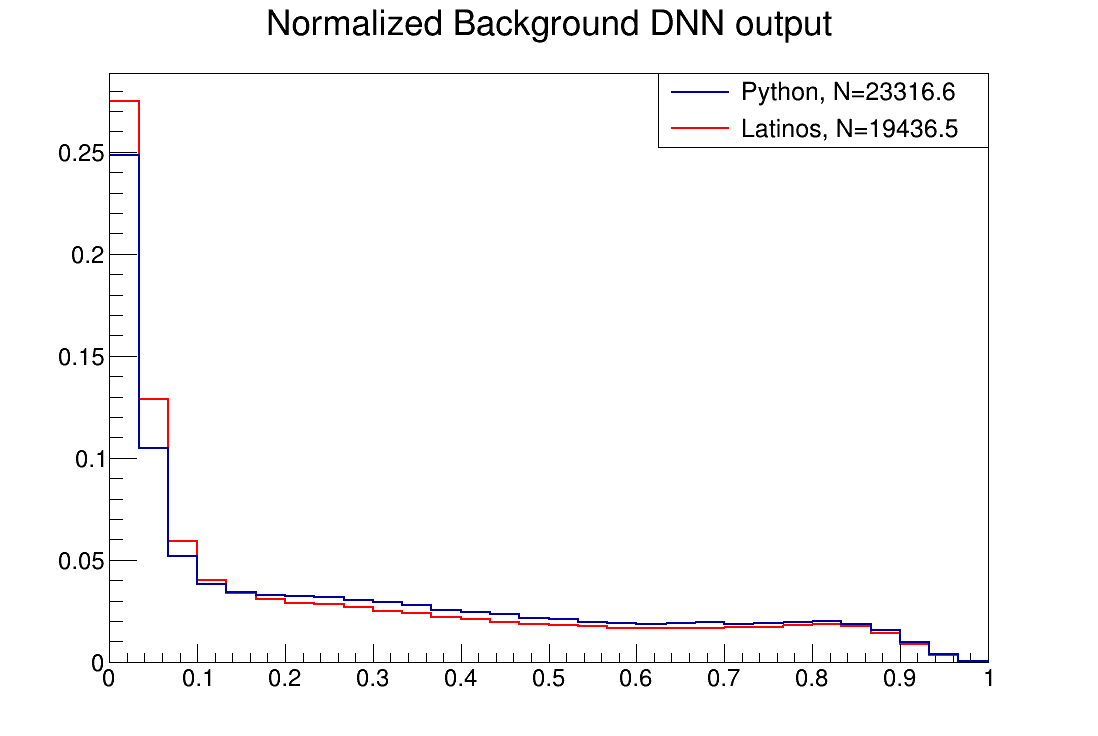

In [47]:
c3 = TCanvas("","")
c3.SetWindowSize(1500,1000)

d.Draw("HIST")
d1.Draw("HIST SAME")

d.Scale(1/(d.Integral()));
d1.Scale(1/(d1.Integral()));

d.SetLineWidth(2)
d.SetTitle("Normalized Background DNN output");

ROOT.gStyle.SetOptStat(0);

legend = ROOT.TLegend(0.6,0.8,0.9,0.9);
legend.AddEntry(d1,"Python, N="+str(round((bkg.weight_).sum()*lumi,1)),"l");
legend.AddEntry(d,"Latinos, N=19436.5","l");

legend.Draw();

c3.Draw()

# Significance

In [10]:
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)

top = bkg[bkg["sample_name"] == "top"]

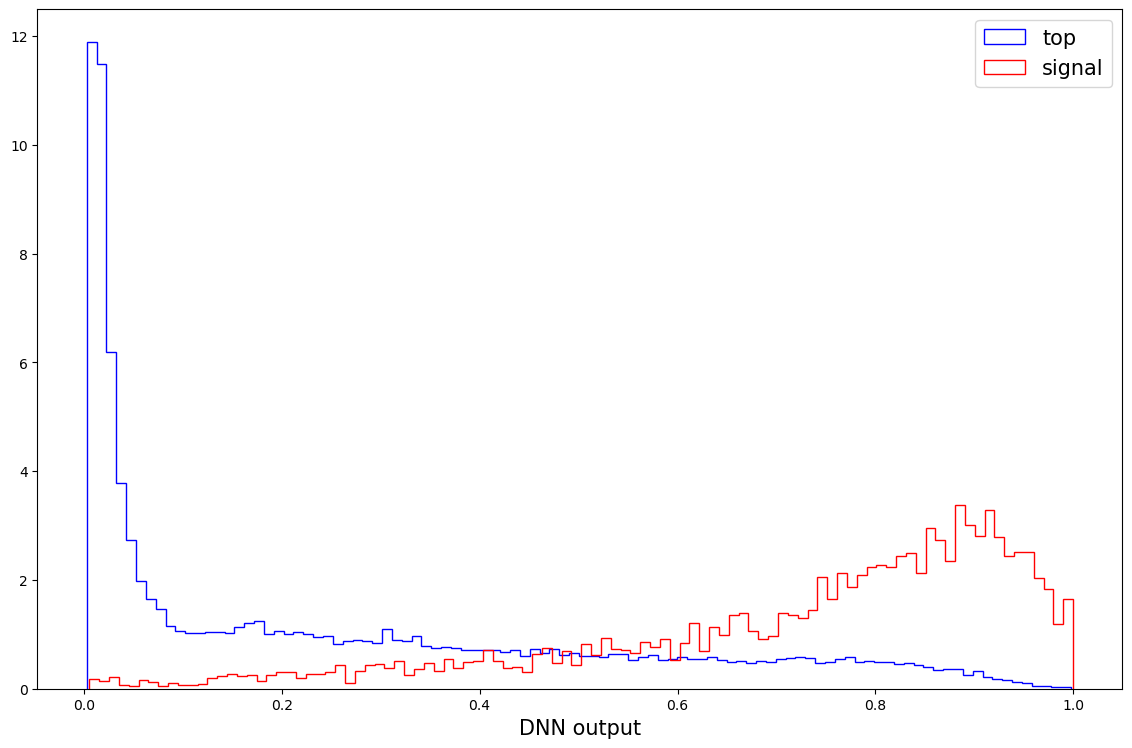

In [11]:
lumi = 59.74

fig, ax1 = plt.subplots(figsize=(14,9), dpi=100)

plt.hist(top["y"], density=True,  weights=top.weight_*lumi, bins=100, label="top",  color="blue", histtype="step")
plt.hist(signal["y"], density=True, weights=signal.weight_*lumi, bins=100, label="signal", color="red", histtype="step")
plt.xlabel("DNN output", fontsize=15)
plt.legend(loc="upper right", fontsize=15)
plt.show()

 Initial number of background events = 23316.60
 Initial number of signal events = 229.03

 signal efficiency = 0.6421
 background efficiency = 0.1036

 significance (before) = 1.50 
 significance (after) = 2.99


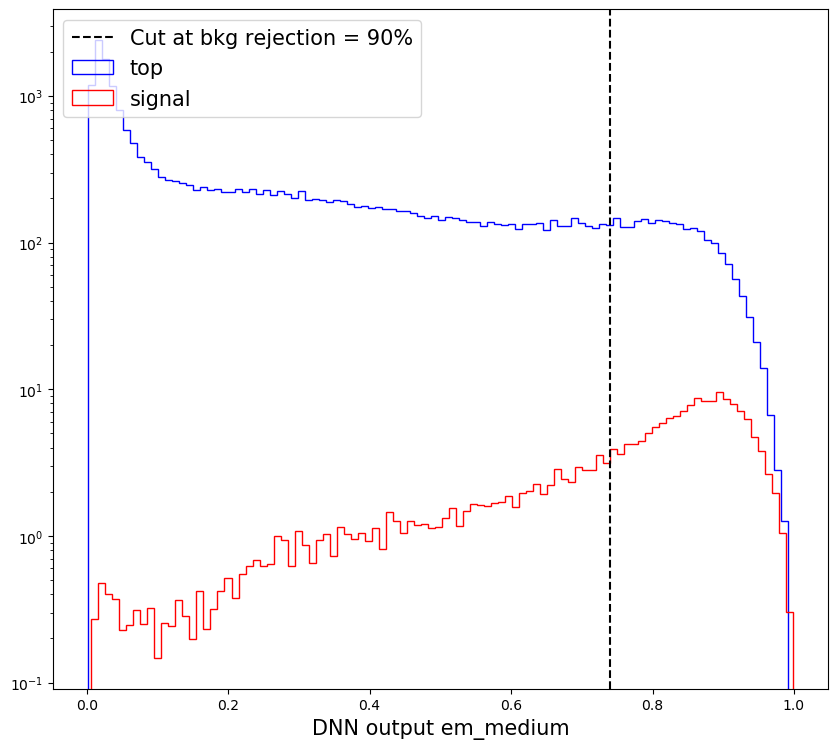

In [24]:
from math import sqrt
import matplotlib.patches as mpatches

lumi = 59.74

fig, ax1 = plt.subplots(figsize=(10,9), dpi=100)

B, B_bins, _ = plt.hist(top["y"],   weights=top.weight_*lumi, bins=100, label="top",  color="blue", histtype="step")
S, S_bins, _ = plt.hist(signal["y"], weights=signal.weight_*lumi, bins=100, label="signal", color="red", histtype="step")

Ni_B = sum(B)
Ni_S = sum(S)

print(" Initial number of background events = {:.2f}\n Initial number of signal events = {:.2f}\n".format(Ni_B, Ni_S))

bd = 1
int_B = 0

while (int_B < (0.1*Ni_B)):
    int_B = sum(B[-bd:])
    bd += 1

int_S = sum(S[-bd:])

plt.axvline(S_bins[-bd], 0, max(B), label='Cut at bkg rejection = 90%', color = "black", linestyle = "dashed")

print(" signal efficiency = {:.4f}\n background efficiency = {:.4f}\n".format(int_S/Ni_S, int_B/Ni_B))

print(" significance (before) = {:.2f} \n significance (after) = {:.2f}".format(Ni_S/sqrt(Ni_B), int_S/sqrt(int_B)))

plt.yscale("log")
plt.xlabel("DNN output "+config["cut"], fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.show()